## MolSSI Molecular Mechanics Interoperable Components
### Conceptual Mockup

This Jupyter Notebook is a conceptual mockup of the MolSSI MM Interoperable Components. The goal of this mockup is to demonstrate the ideas and goals of the components and get feedback on possible design choices.
We present an example Molecular Mechanics pipeline:
 - System Comstruction
 - Minimization and Equilibration
 - Production Run
 - Analysis

For each stage in the pipeline, we have a number of available components, using different codes or operations, that can fill the same role.
Though using different codes and potentially performing different operations, the components that can be used in each stage all operate on the same input parameters and, with the exception of specific analysis operations, provide the same output parameters.

By defining the I/O as a contract between stages, we create a system pipeline that is very modular and easy to adjust between components. More specifically, any component that adheres to the I/O specification of a stage can be used in place of any other component for that stage. The correctness of a specific pipeline, with components in place, is dependent on each component adhering to the I/O specification as well as it performing operations that are applicable to a stage.



### Available Components
We first import the available components for the mockup. Only one component from each stage is necessary to execute the pipeline, but we import all here for clarity.

In [1]:
import os
from mminterconcept.construction import (protein_constructor,
                           protein_constructor_vacuum,
                           protein_constructor_solvate,
                           protein_constructor_solvate_ion)

from mminterconcept.min_eq import (min_eq,
                     gro_minimize,
                     gro_eq_nvt,
                     gro_eq_npt,
                     omm_minimize,
                     omm_eq)

from mminterconcept.production import (production,
                         gromacs_production,
                         openmm_production)

from mminterconcept.analysis import (analysis,
                       mda_com,
                       mda_density,
                       mda_rdf,
                       mda_rmsd,
                       mda_rog,
                       mdtraj_com,
                       mdtraj_density,
                       mdtraj_rdf,
                       mdtraj_rmsd,
                       mdtraj_rog)

_ColormakerRegistry()

### Input processing
Here we start with a PDB file of a system for use in our pipeline.

In [4]:

#mdp = os.path.join(os.path.realpath(__file__), "data", "em.mdp")
mdp = os.path.join(os.getcwd(), os.path.join("mminterconcept", "data", "gmx_mdp", "em.mdp"))

pdbID = '1L2Y'

### System Construction
This stage constructs the system from the given pdbID and mdp file. We have three different types of components that construct a system from a PDB file and an MDP file. We have three different components that utilize the API-schema to construct an initial system. The first component generates a system in a vaccuum, the second performs a solvation, and the third performs a solvation and an ionization. All three components can be used interchangably to generate a system for minimization and equilibration.

#### API-Schema
```python
protein_constructor(mdp, **kwargs) -> Tuple[mdtraj.Trajectory, str]
```

All components for this stage adhere to the above API-Schema. They take as input an mdp and return a tuple containing an mdtraj style Trajectory and a string containing the topology.

In [29]:
#trajectory, topology = protein_constructor_vacuum(mdp, pdbID=pdbID)
#trajectory, topology = protein_constructor_solvate(mdp, pdbID=pdbID)
trajectory, topology = protein_constructor_solvate_ion(mdp, pdbID=pdbID)

/home/sjellis/anaconda3/envs/molssi_comp_test3.7/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


### Minimization and Equilibration
This stage performs a minimization and/or an equilibration of the system, to prepare it for th eproduction run. We provide five different components using two different packages, OpenMM and Gromacs. We provide a minimization component using each code, as well as a few equilibration methods. Any combination of components will produce the proper output needed by the production run.

#### API-Schema
```python
min_eq(*, trajectory: mdtraj.Trajectory, topology: str) -> Tuple[mdtraj.Trajectory, str]
```
All components for this stage adhere to the above API-Schema. They take as input an mdtraj style Trajectory, and a topology as a string. They return a tuple containing an mdtraj style Trajectory and a topology as a string.

In [30]:
trajectory, topology = omm_minimize(trajectory=trajectory, topology=topology)

In [31]:
trajectory, topology = omm_eq(trajectory=trajectory, topology=topology)

### Production Run
This stage performs a production run using a Trajectory and a Topology. We have two different components as an example, one using OpenMM and one using Gromacs to perform the simulation. Either component can be used interchangably to perform the simulation, utilizing the same inputs and providing the same output structure, allowing the pipeline to work regardless of which component is selected.

#### API-Schema
```python
production(*, trajectory: mdtraj.Trajectory, topology: str) -> mdtraj.Trajectory
```
All components for this stage adhere to the above API-Schema. They take as input an mdtraj style Trajectory, and a topology as a string. They return an mdtraj style Trajectory.

In [32]:
trajectory = openmm_production(trajectory=trajectory, topology=topology)
#trajectory = gromacs_production(trajectory=trajectory, topology=topology)

# should we include topology as output too?
# trajectory, topology = openmm_production(trajectory=trajectory, topology=topology)

### System Analysis
This stage performs various analyses onthe results of the Production Run. We have ten different components, five of which utilize MDTraj operations and five which use MDAnalysis operations. This is to simulate developers producing various analysis tools that adhere to a specific input schema, allowing them all to be interchangably used after a production run.

#### API-Schema
```python
analysis(trajectory: mdtraj.Trajectory, topology: mdtraj.Trajectory=None) -> Tuple[np.ndarray, np.ndarray]
```
All components for this stage adhere to the above API-Schema. They take in a Trajectory and a Topology, both in the form of an mdtraj style Trajectory. The outputs of these components are all numpy ndarrays, but not necessarily of the same shape, due to the differences in desired output.

In [33]:
###############################################
############## 3D Visualization ###############
###############################################

from mminterconcept.analysis import ngl_view

path_to_data = os.path.join('mminterconcept', 'data')

# Load charge-neutral alanine dipeptide from pdbfile ~  
pdbFile = os.path.join(path_to_data, 'diAla', 'struct', 'dialanine.pdb')

# Visualize molecule
ngl_view(pdbFile=pdbFile)

NGLWidget()

In [34]:
# pdbID = '1L2Y' # ARTIFICIAL Trp-Cage miniprotein ~ 304 atoms ~ charge 1.0e
# pdbID = '2SAK' # STAPHYLOKINASE  ~ 1973 atoms, charge ~ -3.0e
# pdbID = '1LFH' # LACTOFERRIN globular glycoprotein ~ 10549 atoms, charge ~ 8.0e

ngl_view(pdbID=pdbID)

/home/sjellis/anaconda3/envs/molssi_comp_test3.7/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


NGLWidget(max_frame=37)

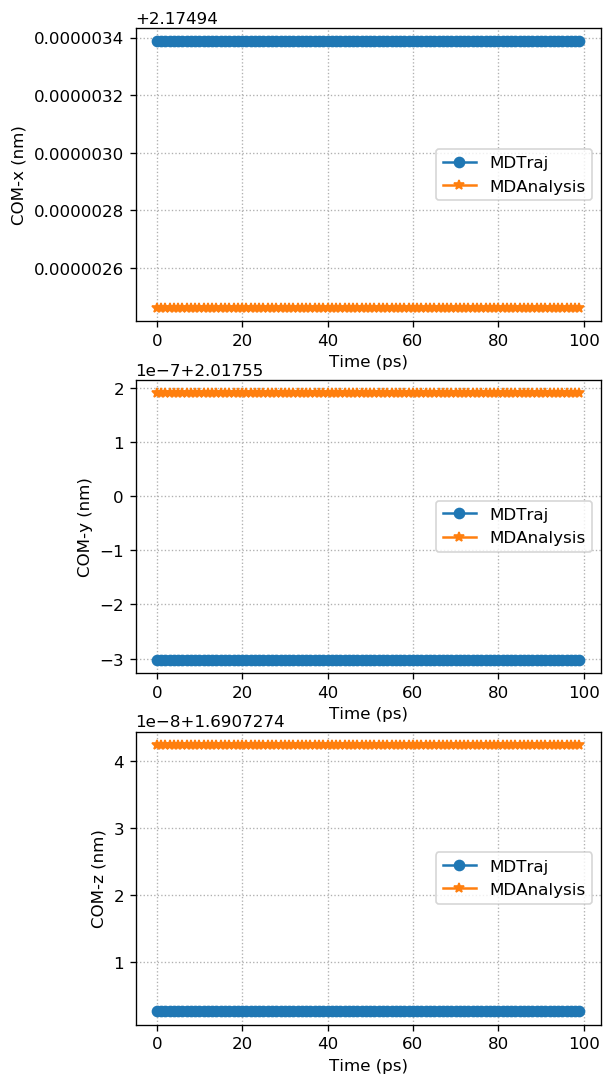

In [35]:
###############################################
############# 2D Temporal Analysis ############
###############################################

# Compute protein center of mass with MDTraj
time_mdt, com_mdt = mdtraj_com(trajectory)

# Compute protein center of mass with MDAnalysis
time_mda, com_mda = mda_com(trajectory)

# Plot the protein center of mass a function of time
from mminterconcept.analysis import plot_com
        
plot_com(time_mdt, com_mdt, time_mda, com_mda)

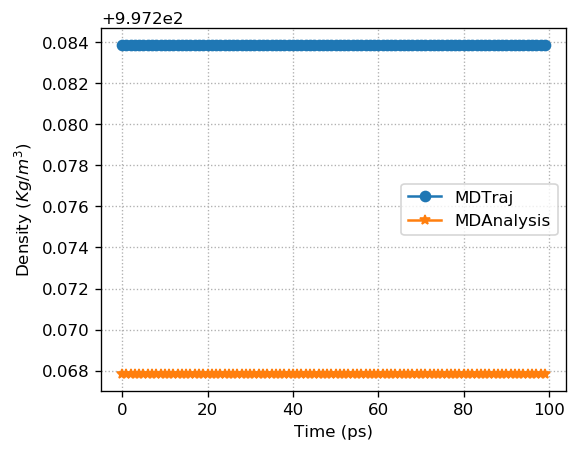

In [36]:
# Compute system density with MDTraj
time_mdt, den_mdt = mdtraj_density(trajectory)

# Compute system density with MDAnalysis
time_mda, den_mda = mda_density(trajectory)

# Plot density as a function of time
from mminterconcept.analysis import plot_den

plot_den(time_mdt, den_mdt, time_mda, den_mda)

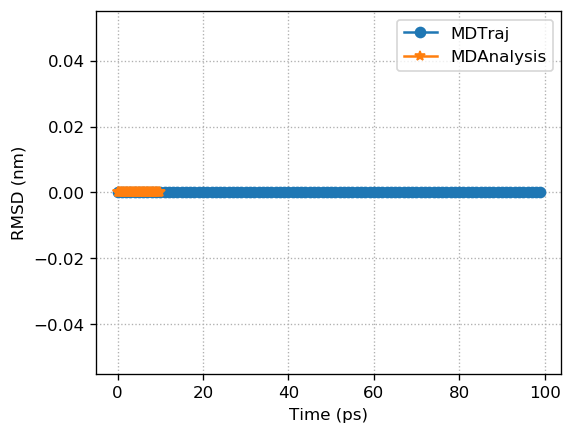

In [37]:
# Compute protein root-mean-square deviation with MDTraj
time_mdt, rmsd_mdt = mdtraj_rmsd(trajectory)

# Compute protein root-mean-square deviation with MDAnalysis
time_mda, rmsd_mda = mda_rmsd(trajectory)

# Plot RMSD as a function of time
from mminterconcept.analysis import plot_rmsd

plot_rmsd(time_mdt, rmsd_mdt, time_mda, rmsd_mda)

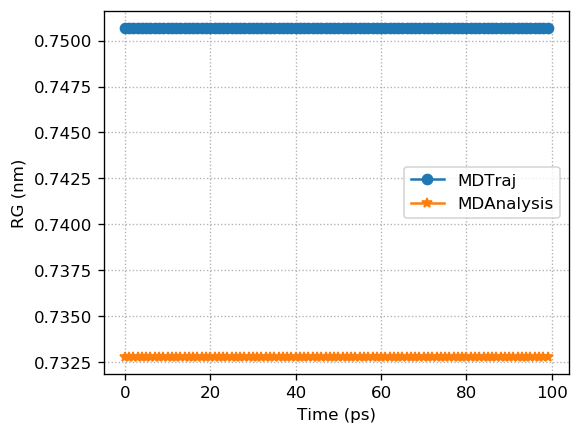

In [38]:
# Compute protein radius of gyration with MDTraj
time_mdt, rg_mdt = mdtraj_rog(trajectory)

# Compute protein radius of gyration with MDAnalysis
time_mda, rg_mda = mda_rog(trajectory)

# Plot RG as a function of time
from mminterconcept.analysis import plot_rg

plot_rg(time_mdt, rg_mdt, time_mda, rg_mda)

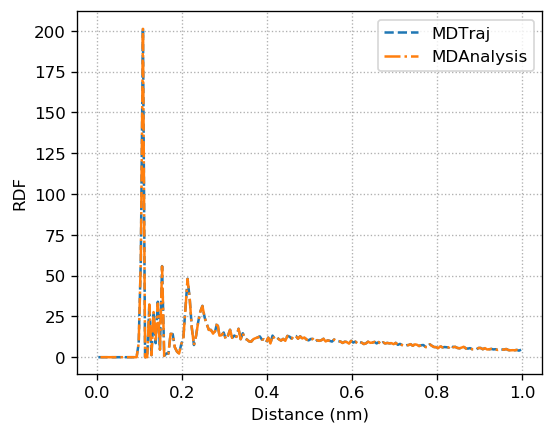

In [39]:
###############################################
############# 2D Spatial Analysis #############
###############################################

# Compute protein radius of gyration with MDTraj
time_mdt, rdf_mdt = mdtraj_rdf(trajectory)

# Compute protein radius of gyration with MDAnalysis
time_mda, rdf_mda = mda_rdf(trajectory)

# Plot RG as a function of time
from mminterconcept.analysis import plot_rdf

plot_rdf(time_mdt, rdf_mdt, time_mda, rdf_mda)